In [389]:
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

df = pd.read_csv("telcocustomerchurn_featured.csv")
# Define the features and target variable
# Define the features and target variable
X = df.drop(columns=['Churn', 'Unnamed: 0', 'Customer Status_Joined', 'Customer Status_Stayed', 'LoyaltyID'])
y = df['Churn']

# StratifiedShuffleSplit 
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=7)
print(sss)

for train_index, test_index in sss.split(X, y):
    print("train:", train_index, "test:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(f"X shape: {X.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y shape: {y.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Save the train and test splits to CSV files
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

StratifiedShuffleSplit(n_splits=5, random_state=7, test_size=0.2,
            train_size=None)
train: [4486 1855 3910 ... 4687  690 5658] test: [ 724  945 4710 ... 3730 1633 2496]
train: [ 937 6833 3567 ... 4257 4716 5657] test: [6171  505 5903 ... 6911 2257 5571]
train: [4793 2570 3406 ...  805 2103 1162] test: [  31 2128 2079 ... 2313 6356 5365]
train: [6799  180 3061 ... 3155 2428  793] test: [3083 4441  980 ... 4552 2903 1479]
train: [ 603 4034 6970 ... 1356 4927 1489] test: [5931 4868 2690 ... 3344 6206 5245]
X shape: (7043, 111)
X_train shape: (5634, 111)
X_test shape: (1409, 111)
y shape: (7043,)
y_train shape: (5634,)
y_test shape: (1409,)


In [391]:
print(X.dtypes)

Count                                 int64
Gender                                int64
Age                                   int64
Under 30                              int64
Senior Citizen                        int64
                                     ...   
Revenue_Cluster_Medium                int64
Revenue_Cluster_High                  int64
Refund_to_Charges_Ratio             float64
Extra_Data_Usage_Cost_Proportion    float64
Lifetime_Value_per_Month            float64
Length: 111, dtype: object


# Multilayer Perceptron (MLP)

A Multilayer Perceptron (MLP) is a deep learning model based on a Feedforward Neural Network, consisting of multiple layers of neurons, where each neuron layer is fully connected to the previous one. MLP can be used to solve various machine learning problems, such as classification, regression, and clustering. Each layer of an MLP is composed of numerous neurons: the input layer receives the input features, the output layer provides the final predictions, and the hidden layers extract features and perform nonlinear transformations. Each neuron receives input from the previous layer, applies a weighted sum and an activation function, and generates the output for the current layer. Through iterative training, MLPs can automatically learn complex relationships between input features and make predictions on new data.
In this study, we aim to use the MLP model to predict which users have a higher probability of churn. Then, we will perform cluster analysis on these high-churn-probability users to identify their common characteristics.

1. MLP implementation of prediction using scikit-learn Scikit-learn: scikit-learn is a machine learning library that provides various algorithms for classification, regression, and clustering. Among them, the MLPClassifier and MLPRegressor classes can be used to build Multilayer Perceptron (MLP) models.

In [394]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

#  Define categorical and numerical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Data preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# Create a pipeline with preprocessing steps and MLP models
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
])

# Training model
pipeline.fit(X_train, y_train)

# Predicting the probability of churn
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # 获取流失概率
print(y_pred_proba)

[5.85592646e-06 2.54391811e-05 1.75802689e-06 ... 9.99991658e-01
 4.30015827e-05 9.99857733e-01]


2. Clustering using K-Means
Cluster analysis of filtered users to find their common features:

In [395]:
import pandas as pd

# Filtering out characteristic data corresponding to users with high churn probability
high_churn_users = X_test[y_pred_proba > 0.7]


In [363]:
from sklearn.cluster import KMeans

# Clustering using K-Means (in this case we have 3 classes)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(high_churn_users_numeric)

# Add the clustering results to the data frame
high_churn_users_numeric['Cluster'] = clusters

print(high_churn_users_numeric.head())


      Unnamed: 0  Count  Gender  Age  Under 30  Senior Citizen  Married  \
1263         245      1       1   77         0               1        0   
4357        2212      1       1   43         0               0        0   
1090         141      1       1   79         0               1        1   
6486         269      1       0   69         0               1        1   
7037        1856      1       0   36         0               0        0   

      Dependents  Number of Dependents  Zip Code  ...  \
1263           0                     0     92373  ...   
4357           0                     0     92411  ...   
1090           0                     0     93101  ...   
6486           0                     0     93627  ...   
7037           0                     0     92028  ...   

      MonthlyCharge_TotalCharges_Ratio  ChurnScore_CLTV  AvgMonthlyGB_Tenure  \
1263                          0.023497           197379                  861   
4357                          1.000000        

D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\胖头鱼\AppData\Local\Temp\ipykernel_8376\2012777352.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_churn_users_numeric['Cluster'] = clusters


In [ ]:
#  Calculate the feature mean for each clustering category
cluster_means = high_churn_users_numeric.groupby('Cluster').mean()

print(cluster_means)

# Visualize the feature means for each clustering category
import matplotlib.pyplot as plt

for cluster_label in cluster_means.index:
    cluster_means.loc[cluster_label].plot(kind='bar', figsize=(10, 6))
    plt.title(f'Cluster {cluster_label} Feature Means')
    plt.xlabel('Feature')
    plt.ylabel('Mean Value')
    plt.show()


          Unnamed: 0  Count    Gender        Age  Under 30  Senior Citizen  \
Cluster                                                                      
0        1388.282443    1.0  0.458015  51.419847  0.145038        0.282443   
1        1485.137615    1.0  0.532110  49.027523  0.165138        0.201835   
2        1432.962406    1.0  0.503759  49.353383  0.127820        0.240602   

          Married  Dependents  Number of Dependents      Zip Code  ...  \
Cluster                                                            ...   
0        0.290076    0.045802              0.122137  93418.000000  ...   
1        0.376147    0.036697              0.064220  93624.550459  ...   
2        0.398496    0.052632              0.120301  93504.330827  ...   

         AvgMonthlyGB_StreamServices  MonthlyCharge_TotalCharges_Ratio  \
Cluster                                                                  
0                          34.190840                          0.273155   
1               

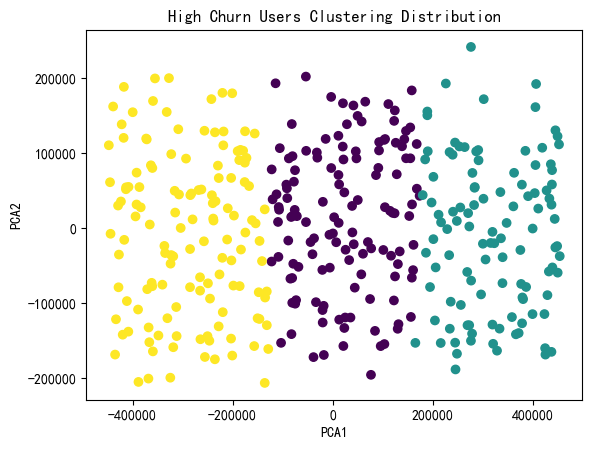

In [205]:
# Dimensionality reduction using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(high_churn_users_numeric.drop('Cluster', axis=1))

# Visualization of clustering results
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('High Churn Users Clustering Distribution')
plt.show()


3. Clustering results analysis，view the characteristic mean value of each clustering category and look for patterns:

C:\Users\胖头鱼\AppData\Local\Temp\ipykernel_8376\4051949666.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_churn_users_numeric['Cluster'] = high_churn_users_df['Cluster']


          Unnamed: 0  Count    Gender        Age  Under 30  Senior Citizen  \
Cluster                                                                      
0        1527.831858    1.0  0.495575  49.442478  0.106195        0.212389   
1        1409.459459    1.0  0.554054  47.729730  0.243243        0.256757   
2        1383.784946    1.0  0.473118  51.209677  0.129032        0.258065   

          Married  Dependents  Number of Dependents      Zip Code  ...  \
Cluster                                                            ...   
0        0.176991    0.079646              0.221239  93393.247788  ...   
1        0.675676    0.040541              0.081081  93147.216216  ...   
2        0.333333    0.026882              0.043011  93723.543011  ...   

         AvgMonthlyGB_StreamServices  MonthlyCharge_TotalCharges_Ratio  \
Cluster                                                                  
0                           5.079646                          0.641088   
1               

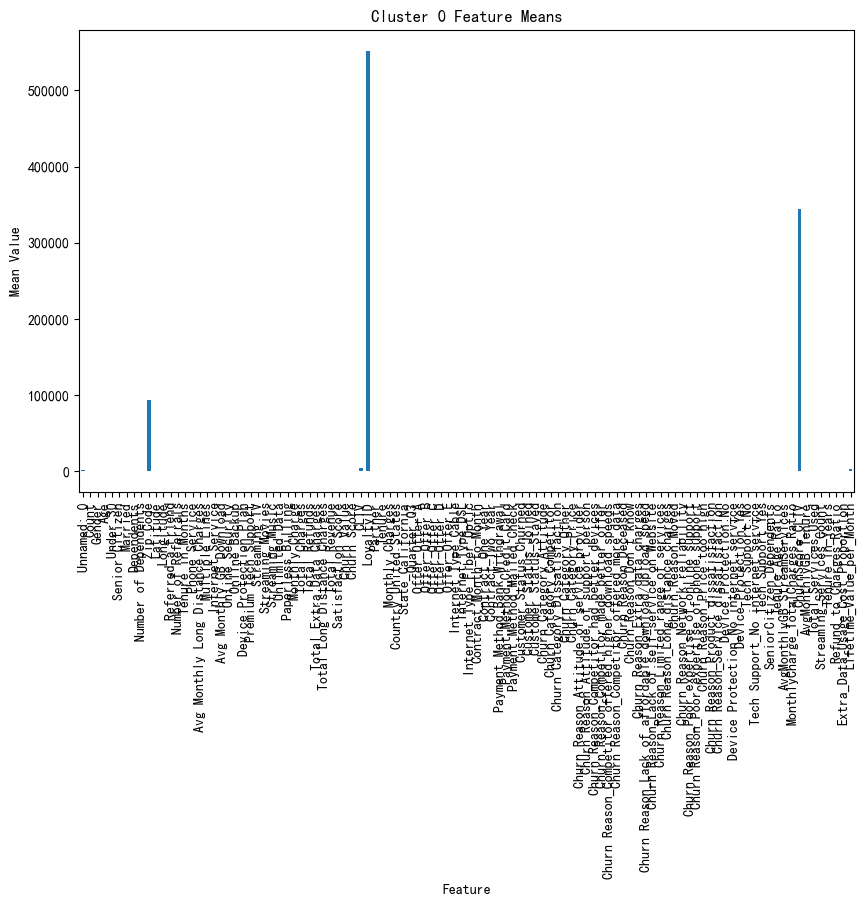

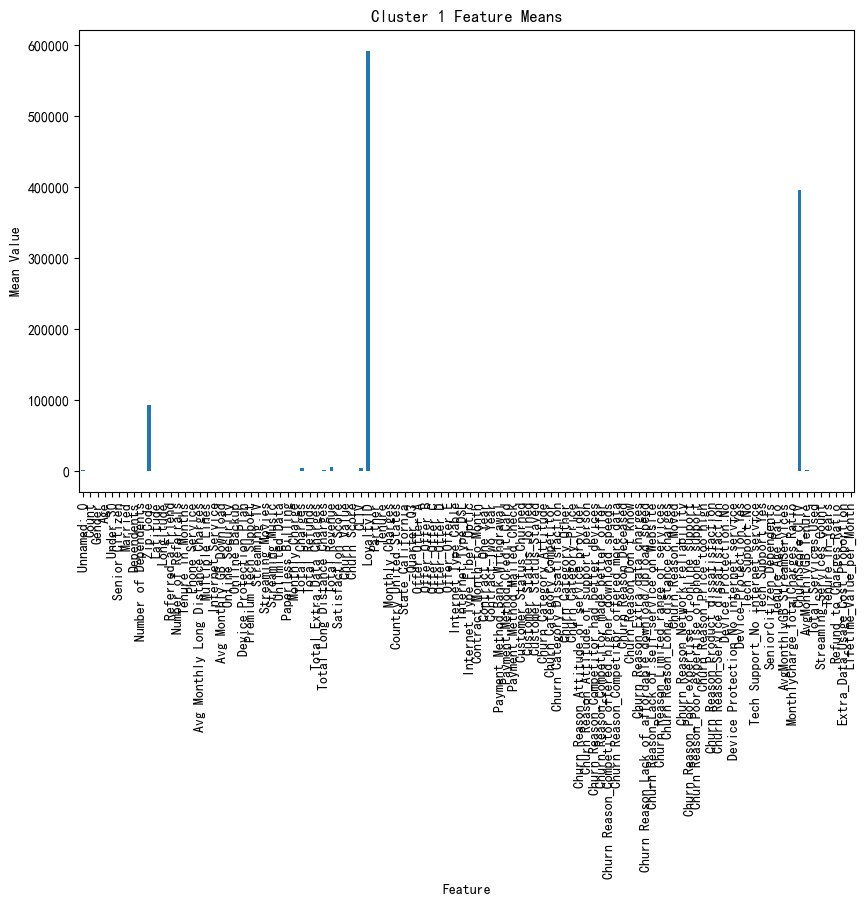

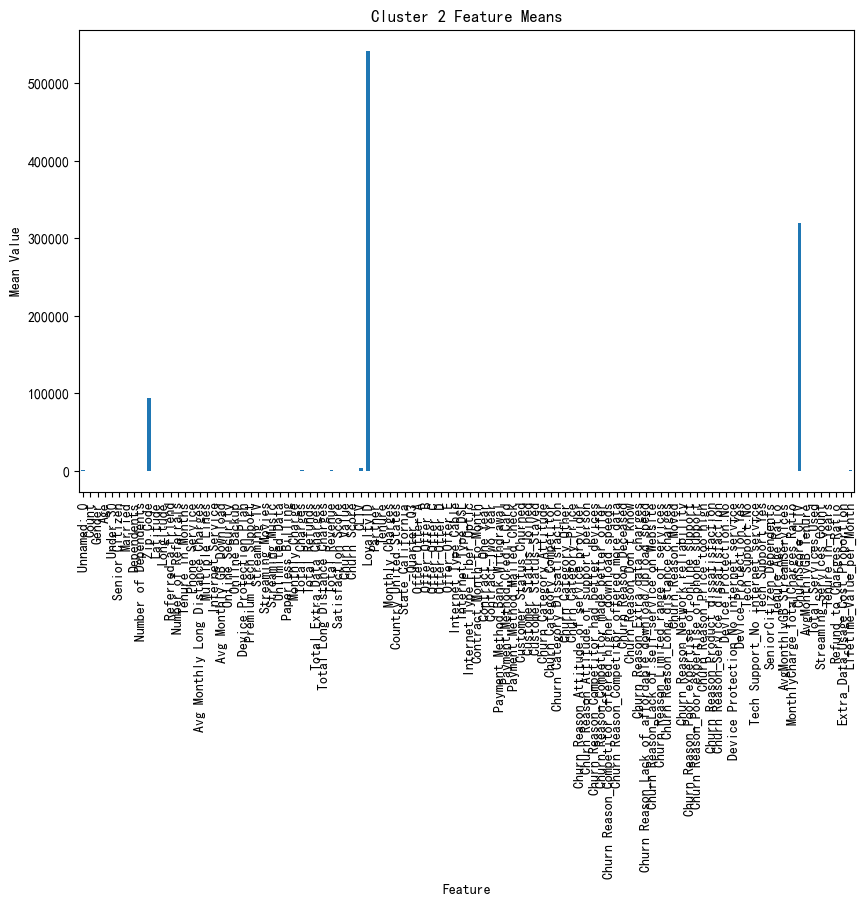

In [339]:
# Select only feature columns of numeric type
numerical_columns = high_churn_users_df.select_dtypes(include=['int64', 'float64']).columns
high_churn_users_numeric = high_churn_users_df[numerical_columns]

# Preserve clustered columns
high_churn_users_numeric['Cluster'] = high_churn_users_df['Cluster']

# Calculate the feature mean for each cluster
cluster_analysis = high_churn_users_numeric.groupby('Cluster').mean()

# View the feature means for each category in the clustering results
print(cluster_analysis)

# Visualize the feature means for each clustering category
import matplotlib.pyplot as plt

for cluster_label in cluster_analysis.index:
    plt.figure(figsize=(10, 6))
    cluster_analysis.loc[cluster_label].plot(kind='bar')
    plt.title(f'Cluster {cluster_label} Feature Means')
    plt.xlabel('Feature')
    plt.ylabel('Mean Value')
    plt.show()


4. Analyzing Feature Importance: In the process of churn probability prediction, SHAP (SHapley Additive exPlanations) can be used to explain which features play a key role in predicting churn.

          Unnamed: 0  Count    Gender        Age  Under 30  Senior Citizen  \
Cluster                                                                      
0        1527.831858    1.0  0.495575  49.442478  0.106195        0.212389   
1        1409.459459    1.0  0.554054  47.729730  0.243243        0.256757   
2        1383.784946    1.0  0.473118  51.209677  0.129032        0.258065   

          Married  Dependents  Number of Dependents      Zip Code  ...  \
Cluster                                                            ...   
0        0.176991    0.079646              0.221239  93393.247788  ...   
1        0.675676    0.040541              0.081081  93147.216216  ...   
2        0.333333    0.026882              0.043011  93723.543011  ...   

         AvgMonthlyGB_StreamServices  MonthlyCharge_TotalCharges_Ratio  \
Cluster                                                                  
0                           5.079646                          0.641088   
1               

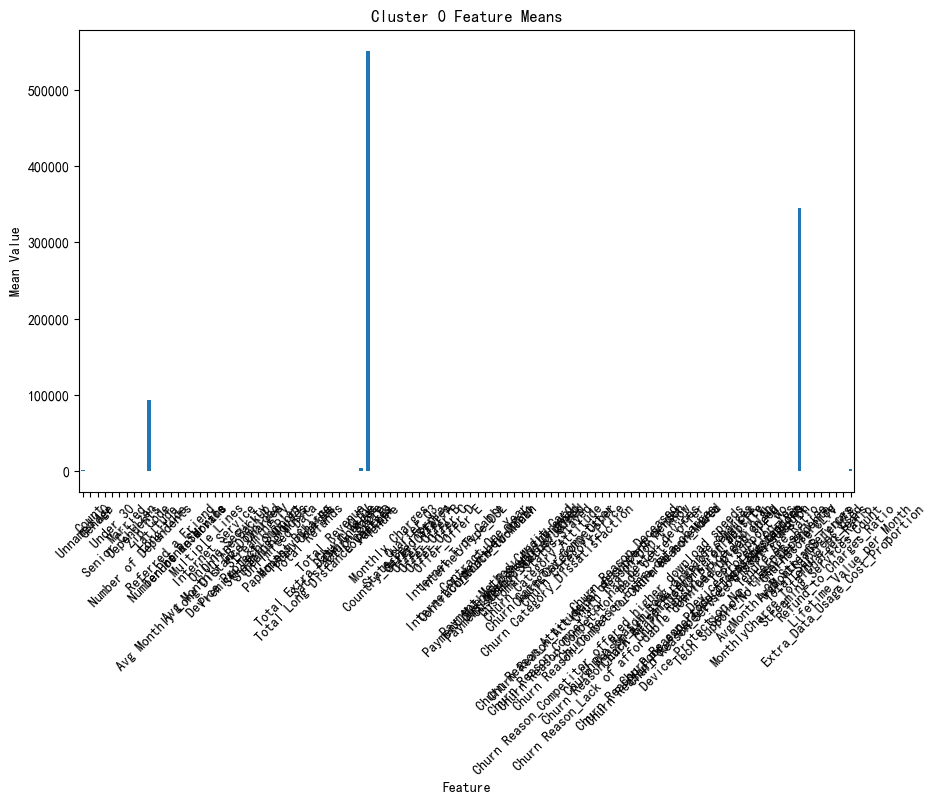

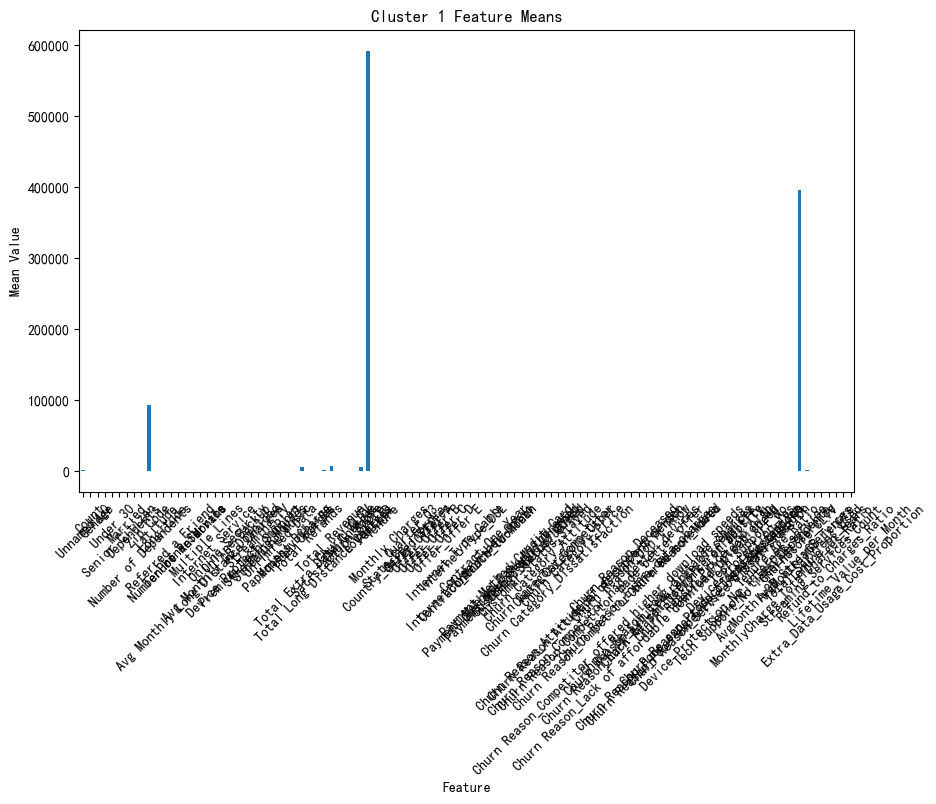

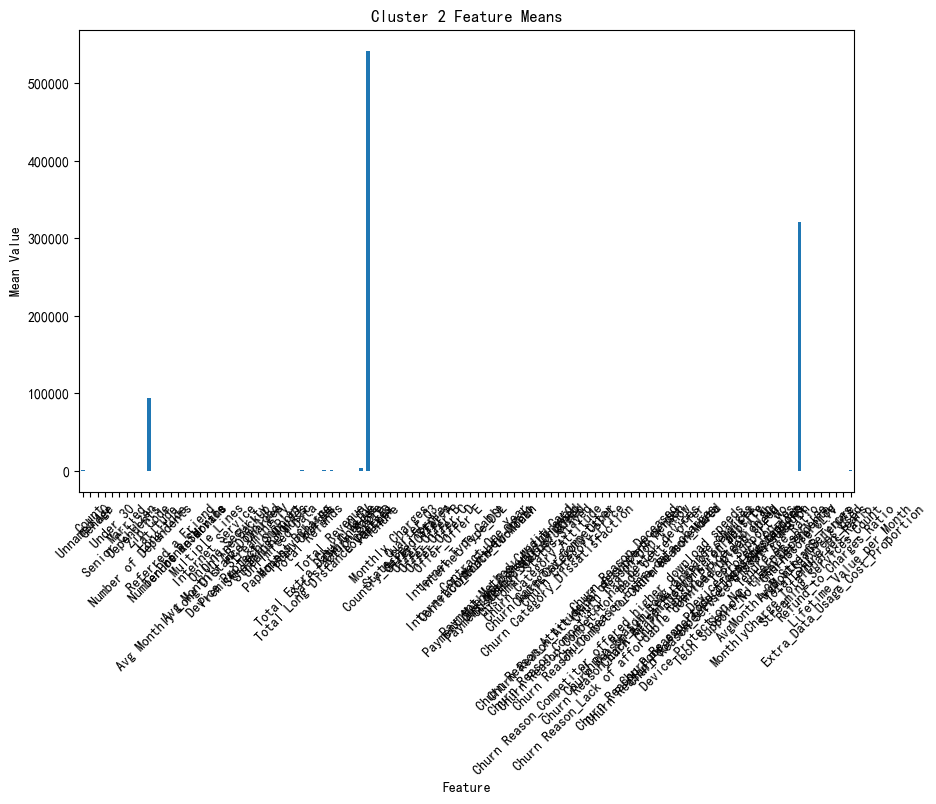

In [367]:
import matplotlib.pyplot as plt

numerical_features = high_churn_users_df.select_dtypes(include=['int64', 'float64']).columns

cluster_analysis = high_churn_users_df[numerical_features].groupby(high_churn_users_df['Cluster']).mean()

print(cluster_analysis)


for cluster_label in cluster_analysis.index:
    plt.figure(figsize=(10, 6))
    cluster_analysis.loc[cluster_label].plot(kind='bar')
    plt.title(f'Cluster {cluster_label} Feature Means')
    plt.xlabel('Feature')
    plt.ylabel('Mean Value')
    plt.xticks(rotation=45)
    plt.show()


In [342]:
print(cluster_analysis)

          Unnamed: 0  Count    Gender        Age  Under 30  Senior Citizen  \
Cluster                                                                      
0        1527.831858    1.0  0.495575  49.442478  0.106195        0.212389   
1        1409.459459    1.0  0.554054  47.729730  0.243243        0.256757   
2        1383.784946    1.0  0.473118  51.209677  0.129032        0.258065   

          Married  Dependents  Number of Dependents      Zip Code  ...  \
Cluster                                                            ...   
0        0.176991    0.079646              0.221239  93393.247788  ...   
1        0.675676    0.040541              0.081081  93147.216216  ...   
2        0.333333    0.026882              0.043011  93723.543011  ...   

         AvgMonthlyGB_StreamServices  MonthlyCharge_TotalCharges_Ratio  \
Cluster                                                                  
0                           5.079646                          0.641088   
1               

## Conclusion

From the clustering results, the following features appear to play a significant role in distinguishing customer segments:
MonthlyCharge_TotalCharges_Ratio: The ratio of monthly charges to total charges shows significant differences across clusters, indicating that this feature is crucial in influencing customer churn and clustering outcomes.
AvgMonthlyGB_Tenure: The average monthly GB usage combined with tenure is also very useful for determining the risk of customer churn.
Total_Services_Used: The number of services used varies greatly across clusters. Heavy users may have a higher or lower likelihood of churn, depending on their satisfaction with the services.

## Evaluation of the modelfeature_names)


In [369]:
# Prediction through MLP modeling
y_pred = pipeline.predict(X_test)  # 获得分类标签
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # 获得正类的预测概率，用于计算 AUC


In [375]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", auc)


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
AUC: 1.0
